## Barra specific return PnL

In [107]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.datasets import grunfeld
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm
from rich.progress import track

np.set_printoptions(
    precision=3,      # Number of decimal places
    linewidth=100,    # Maximum number of characters per line 
    edgeitems=3       # Number of array items in summary on each edge
)

def nearest_psd(A):
    """Find the nearest positive-semidefinite matrix to A"""
    B = (A + A.T) / 2
    eigval, eigvec = np.linalg.eigh(B)
    eigval[eigval < 0] = 0
    return eigvec @ np.diag(eigval) @ eigvec.T

### Notations

* $w$ portfolio, $n$ assets
* $\beta_t$ Barra loadings at time $t$ - available pre-open where $t$ is the index of current day
* $\beta^j$ is the $j$-th column
* dim of $\beta_t$ is $n \times p$
* $r_t = \beta_t \, R_t + e_t$, where
    * $r_t$ is the close to close to close return on day $t$
    * $R_t$ the factor return
    * $e_t$ are specific returns

### Orthogonal projection

If $\beta_t$ is constant, the pnl obtained using specific retun can be achieved with raw returns
* Let $\tilde w_t = \left( I - \beta_t (\beta_t' \beta_t)^{-1} \beta_t'  \right) \, w_t$
* $\tilde w_{t-1} \, r_t \approx w_{t-1} \, e_t$
    * $\tilde w_{t-1} \, r_t = w'_{t-1} \left( r_t - \beta_{t-1} (\beta_{t-1}' \beta_{t-1})^{-1} \beta_{t-1}' r_t\right)$
    * Since $R_t = (\beta_t' \beta_t)^{-1} \beta_t' \, r_t$ if $\beta_{t-1} = \beta_t$, equality holds
* Portfolio $\tilde w_t$ is built using orthogonal projection of $w_t$ onto the space spaned by $\beta_t^j$ portfolios
* Let $p(w_t)$ be the projection of $w_t$ on $\langle \beta_t^1,\ldots, \beta_t^p\rangle$
* $p(w_t) = \beta_t (\beta_t' \beta_t)^{-1} \beta_t'\, w_t$ and $\tilde w_t = w_t - p(w_t)$

### Optim

* If a portfolio has no factor exposure, $\beta^j w = 0$, then pnl in specific return equals pnl in raw returns
* Using $r = \beta \, R + e$, on can decompose the covariance of $\Sigma$ ito factor and idiosyncratic covariance
* $\Sigma = \beta R R' \beta' + ee' + 2 \beta R e'$
* $\beta R R' \beta$ is the factor variance
* $ee'$ is the specific risk
* $\beta R e' = \beta L \beta' \Sigma \left(I - \beta L \beta' \right)$, where $L = (\beta' \beta)^{-1}$

The idea is that maybe, optim, and minimization of factor risk can achieve factor exposure neutralization and <br>
eventually make it possible to get specific pnl, i.e. $\tilde w_{t-1} \, r_t \approx w_{t-1} \, e_t$

#### Todo
* Generate $r$
* Set constant $\beta$
* Compute or set $R$ and $e$
* Compute $\Sigma$, factor covariance, idiosync covariance and factor idiosync covariance $\beta R e'$
* Check identity on explained residual covariance
* Setup optim problem with all or part of
    * max pnl - factor risk - idiosync risk - sqrt idiosync risk - tcost
    * |w| <= V, pct GMV
    * |dw| <= V
    * |Sum w| <= Delta max
* O1
    * max pnl - factor risk
    * Compare pnl and check one recovers pnl of spec returns
* O2
    * Add elastic net for spec return risk
* O3
    * Add linear tcost
* O4
    * Add constraints

#### Make data

In [240]:
# Set random seed for reproducibility
# np.random.seed(42)

# Parameters
T = 500
n = 100
p = 10

# Generate data
beta = np.zeros((T,n,p), dtype=np.float64)
beta_ref = np.random.normal(size=n*p).reshape((n,p))
beta[:,:,:] = beta_ref

# Generate returns from factors
R = np.random.normal(size=T*p).reshape((T,p)) 

# Generate returns
r = np.zeros((T,n))
r_expl = np.zeros((T,n))

# Generate noise
e = 5*np.random.normal(size=T*n).reshape((T,n))

# Compute factor returns and explained returns
for t in range(T):
    r_expl[t,:] = beta[t,:,:] @ R[t,:]
    r[t,:] = r_expl[t,:] + e[t,:]

## make alpha

alpha = np.random.normal(size=T*n).reshape((T,n))
alpha[:(T-1)] = alpha[:(T-1)] + 0.005*r[1:T]

## covariances
sigma = np.cov(r.T)
eta = np.cov(R.T)
sigma_factor = nearest_psd(beta_ref @ np.cov(R.T) @ beta_ref.T)
sigma_idiosync = nearest_psd(np.cov(e.T))
U = np.diag(sigma_idiosync)

## tcost
kappa = 0.05*np.ones(n)

#### Check covariance

In [241]:
np.linalg.norm(sigma), np.linalg.norm(sigma_factor), np.linalg.norm(sigma_idiosync) 

(np.float64(504.9862542670919),
 np.float64(348.75457148228304),
 np.float64(272.61070137010296))

#### max `pnl - factor_risk`

In [242]:
# store solution
w_array = np.zeros((T,n))

I = np.eye(n)

# Define the optimization variable (portfolio weights)
w = cp.Variable(n)
dw = cp.Variable(n)
z = cp.Variable(p)



In [243]:
#for t in tqdm(range(T)):
for t in track(range(T), description = "optim"):
    objective = cp.Maximize(alpha[t,:] @ w - 
                            #cp.quad_form(w, sigma) - 
                            10.*cp.quad_form(z, eta) - 
                            1.*cp.quad_form(w, sigma_idiosync) - 
                            1.*cp.sum(cp.abs(w)/U) - 
                            1*cp.quad_form(w, np.diag(U)) - 
                            kappa @ cp.abs(dw))

    constraints = [
        z == beta_ref.T @ w,
        #cp.sum(w) == 0,
        #w >= -1.,        
        #w <= 1.
    ]

    # Create and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK)

    # Get the optimal weights
    w_array[t,:] = w.value

Output()

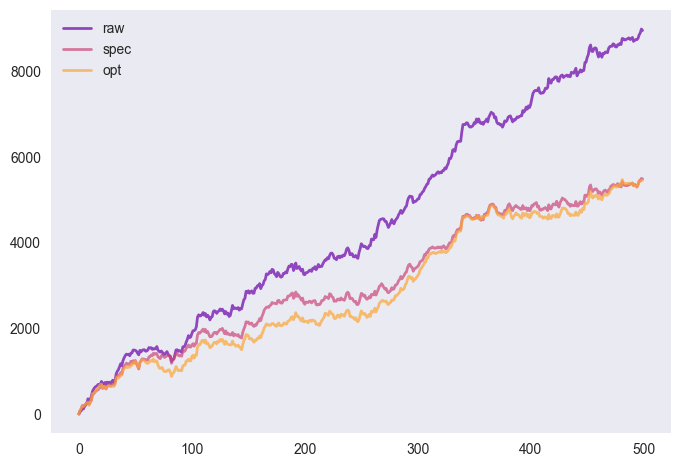

In [244]:
pnl_df = pd.DataFrame(np.zeros((T,3)), columns=["raw","spec","opt"])
pnl_df.loc[1:,"raw"] = np.sum(alpha[0:(T-1),:]*r[1:,:], axis=1)
pnl_df.loc[1:,"spec"] = np.sum(alpha[0:(T-1),:]*e[1:,:], axis=1)
pnl_df.loc[1:,"opt"] = np.sum(w_array[0:(T-1),:]*r[1:,:], axis=1)

vol_ratio = np.std(pnl_df.spec)/np.std(pnl_df.opt)

cmap = cm.plasma
plt.plot(np.cumsum(pnl_df.raw), lw = 2, color = cmap(0.2), alpha=0.7, label="raw")
plt.plot(np.cumsum(pnl_df.spec), lw = 2, color = cmap(0.5), alpha=0.7, label="spec")
plt.plot(vol_ratio*np.cumsum(pnl_df.opt), lw = 2, color = cmap(0.8), alpha=0.7, label="opt")
plt.legend()
plt.grid()

## Codex

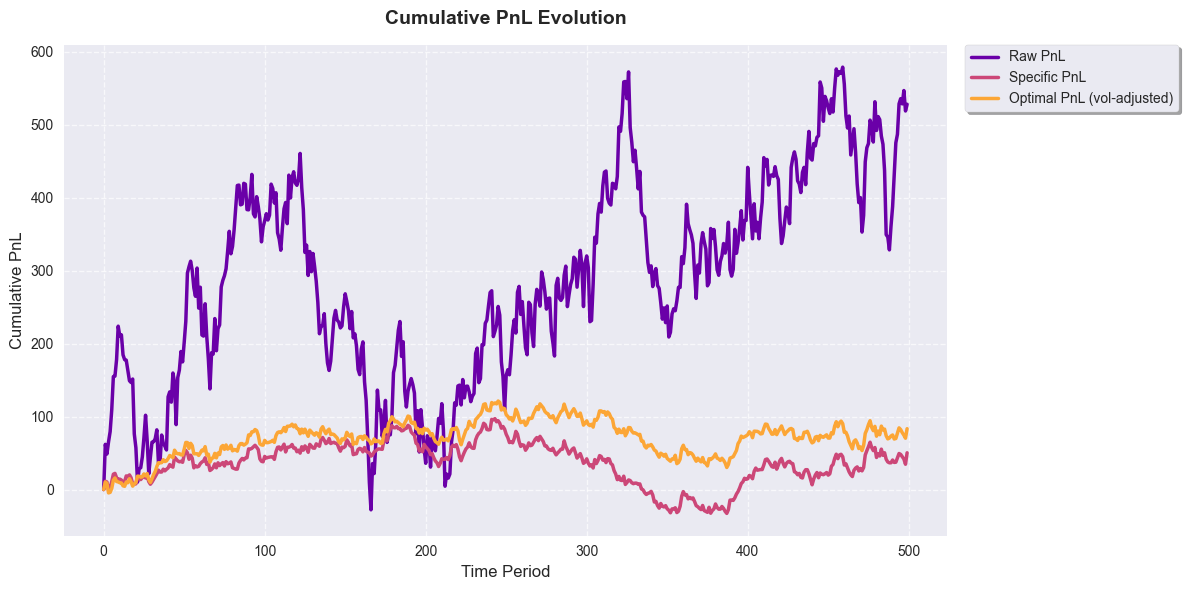

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Configuration du style
plt.style.use('seaborn-v0_8')  # ou simplement 'default' si cette erreur persiste
plt.figure(figsize=(12, 6))

# Préparation des données
cumsum_raw = np.cumsum(pnl_df.raw)
cumsum_spec = np.cumsum(pnl_df.spec) 
cumsum_opt = vol_ratio * np.cumsum(pnl_df.opt)

# Création du graphique
plt.plot(cumsum_raw, lw=2.5, label="Raw PnL", color=cmap(0.2))
plt.plot(cumsum_spec, lw=2.5, label="Specific PnL", color=cmap(0.5))
plt.plot(cumsum_opt, lw=2.5, label="Optimal PnL (vol-adjusted)", color=cmap(0.8))

# Personnalisation
plt.title("Cumulative PnL Evolution", pad=15, fontsize=14, fontweight='bold')
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Cumulative PnL", fontsize=12)

# Amélioration de la grille
plt.grid(True, linestyle='--', alpha=0.7)

# Personnalisation de la légende
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., 
          frameon=True, fancybox=True, shadow=True)

# Ajustement des marges
plt.tight_layout()

# Formatage des axes
def format_axis(x, p):
    return f"{x:,.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_axis))

# Personnalisation des bordures
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)